In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


In [2]:
def encoded_pixels_to_masks(fname: str, df: pd.DataFrame):
    fname_df = df[df['ImageId'] == fname]
    masks = np.zeros((256 * 1600, 4), dtype=int) # float32 is V.Imp

    for i_row, row in fname_df.iterrows():
        cls_id = row['ClassId']
        encoded_pixels = row['EncodedPixels']
        if encoded_pixels is not np.nan:
            pixel_list = list(map(int, encoded_pixels.split(' ')))
            for i in range(0, len(pixel_list), 2):
                start_pixel = pixel_list[i] - 1
                num_pixel = pixel_list[i+1]
                masks[start_pixel:(start_pixel+num_pixel), cls_id-1] = 1

    masks = masks.reshape(256, 1600, 4, order='F')

    return masks

def masks_to_encoded_pixels(masks: np.ndarray):
    masks = masks.reshape(256*1600, 4, order='F')
    encoded_pixels_list = []
    for cls_id in range(4):
        cls_mask = masks[:, cls_id]
        cls_mask = cls_mask.reshape(256, 1600, order='F')
        cls_mask = cls_mask.T.flatten()
        prev_pixel = 0
        prev_pixel_val = 0
        encoded_pixels = []
        for i, pixel_val in enumerate(cls_mask):
            if pixel_val != prev_pixel_val:
                if pixel_val == 1:
                    start_pixel = i + 1
                    encoded_pixels.append(start_pixel)# - prev_pixel) Исправила ошибку
                else:
                    num_pixel = i - prev_pixel
                    encoded_pixels.append(num_pixel)
                prev_pixel = i
                prev_pixel_val = pixel_val
        encoded_pixels_list.append(encoded_pixels)
    return encoded_pixels_list # shape: 4x[]

### Sample example

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Your code starts from here

In [4]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.0 MB/s eta 0:00:00


In [5]:
class SeverstalSteelDataset(Dataset):
    def __init__(self, fnames, df, img_dir, transform=None):
        self.fnames = fnames
        self.df = df
        self.img_dir = img_dir
        self.fnames = fnames
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_id = self.fnames[idx]
        img_path = os.path.join(self.img_dir, img_id)
        img = np.array(Image.open(img_path).convert('RGB'))
        masks = encoded_pixels_to_masks(img_id, self.df)
        if self.transform:
            img = self.transform(image=img)['image']
        img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
        masks = torch.tensor(masks, dtype=torch.float32).permute(2, 0, 1)
        return img_id, img, masks

#def collate_fn(batch_items):
    # YOUR CODE HERE
    #return batched_fnames, batched_imgs, batched_masks

In [6]:
import segmentation_models_pytorch as smp

class SegModel(torch.nn.Module):
    def __init__(self):
        super(SegModel, self).__init__()
        self.model = smp.Unet(encoder_name='resnet34', encoder_weights='imagenet', classes=4, activation=None)

    def forward(self, x):
        return self.model(x)


In [7]:
def load_data(train_val_csv, test_csv, train_val_img_dir, test_img_dir):

    train_val_df = pd.read_csv(train_val_csv)
    train_val_fnames = pd.unique(train_val_df.ImageId)
    test_df = pd.read_csv(test_csv)
    test_fnames = pd.unique(test_df.ImageId)

    train_fnames, val_fnames = train_test_split(train_val_fnames, test_size=0.2)

    train_dataset = SeverstalSteelDataset(train_fnames, train_val_df, train_val_img_dir)
    val_dataset = SeverstalSteelDataset(val_fnames, train_val_df, train_val_img_dir)
    test_dataset = SeverstalSteelDataset(test_fnames,test_df, test_img_dir)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

    return train_loader, val_loader, test_loader

In [8]:
def dice_score(y_true, y_pred, smooth=1e-6):
    res = (y_true * y_pred).sum(dim = 3).sum(dim = 2)
    res = (2. * res + smooth) / (y_true.sum(dim = 3).sum(dim = 2) + y_pred.sum(dim = 3).sum(dim = 2) + smooth)  # 2 × |A ∩ B| / (|A| + |B|)
    return res.mean(0)

In [9]:
def init_model(lr, device):
    model = SegModel().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    return model, criterion, optimizer

def train(model, criterion, optimizer, train_loader, val_loader, epochs, device):
    for epoch in range(epochs):
        model.train()
        rloss = 0
        print('epoch:', epoch)
        i, k, best_val_ds = 0, 0, 0
        dice_scores = torch.zeros(1, 4).to(device)
        for fnames, images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            i = len(fnames)
            rloss += loss.item() * i
            k += i

            pred = torch.sigmoid(outputs) > 0.5
            dice = dice_score(masks, pred)
            dice_scores = dice_scores + dice * i
            #print('dice_:', dice, dice.mean(0))

        val_dice_score = evaluate(model, val_loader, device)
        d = val_dice_score.mean()
        print(val_dice_score, d, best_val_ds)
        if d > best_val_ds:
            torch.save(model.state_dict(), f"drive/My Drive/data/model_{epoch+11}.pth")
            best_val_ds = d

        rloss /= k
        dice_scores = dice_scores / k
        print(f'Epoch: {epoch+1}, Loss: {rloss}, Test Dice Scores: {dice_scores}, {dice_scores.mean()}, Val Dice Scores: {val_dice_score}, {d}')
    return model

def evaluate(model, loader, device):
    model.eval()
    dice_scores = torch.zeros(1, 4).to(device)
    k = 0
    with torch.no_grad():
        for fnames, images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            pred = torch.sigmoid(outputs) > 0.5
            i = len(fnames)
            dice_scores = dice_scores + dice_score(masks, pred).to(device) * i
            k += i
            #print('val:', dice_scores/k)

    return  dice_scores/k

In [10]:
train_val_csv = 'drive/My Drive/data/train.csv'
test_csv = 'drive/My Drive/data/test.csv'
train_val_img_dir = 'drive/My Drive/data/train_images'
test_img_dir = 'drive/My Drive/data/test_images'

lr = 1e-4
epochs = 1#0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_loader, val_loader, test_loader = load_data(train_val_csv, test_csv, train_val_img_dir, test_img_dir)

In [11]:
device

device(type='cuda')

In [12]:
model, criterion, optimizer = init_model(lr, device)
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

SegModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

In [ ]:
train(model, criterion, optimizer, train_loader, train_loader, epochs=2, device=device)

epoch: 0
tensor([[0.9221, 0.9638, 0.7906, 0.9478]], device='cuda:0') tensor(0.9061, device='cuda:0') 0
Epoch: 1, Loss: 0.01302802800015733, Test Dice Scores: tensor([[0.8835, 0.9638, 0.7672, 0.9623]], device='cuda:0'), 0.894202709197998, Val Dice Scores: tensor([[0.9221, 0.9638, 0.7906, 0.9478]], device='cuda:0'), 0.9060593247413635
epoch: 1
tensor([[0.9218, 0.9638, 0.7766, 0.9560]], device='cuda:0') tensor(0.9045, device='cuda:0') 0
Epoch: 2, Loss: 0.011083893271810072, Test Dice Scores: tensor([[0.8983, 0.9638, 0.7928, 0.9715]], device='cuda:0'), 0.9066044688224792, Val Dice Scores: tensor([[0.9218, 0.9638, 0.7766, 0.9560]], device='cuda:0'), 0.9045396447181702


SegModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

Т.к. вычисления проходили небыстро и ресурсы на коллабе заканчивались, запускала эпохи партиями, сохраняя веса. Всего получилось 11 эпох и 11 моделей.
Лучшим результатом оказалась модель 8.
Данные по разным эпохам:

Epoch: 0, Loss: 0.21693880801541146, Test Dice Scores: tensor([[0.3661, 0.4798, 0.4470, 0.4122]], device='cuda:0'), 0.42627817392349243, Val Dice Scores: tensor([[0.8511, 0.9625, 0.5931, 0.9433]], device='cuda:0'), 0.8374952673912048

Epoch: 1, Loss: 0.048147389830131324, Test Dice Scores: tensor([[0.8603, 0.9625, 0.5754, 0.8868]], device='cuda:0'), 0.8212220072746277, Val Dice Scores: tensor([[0.8622, 0.9625, 0.5949, 0.8827]], device='cuda:0'), 0.8255628347396851

Epoch: 2, Loss: 0.03103228364578558, Test Dice Scores: tensor([[0.8622, 0.9625, 0.6101, 0.9120]], device='cuda:0'), 0.8366729021072388, Val Dice Scores: tensor([[0.8622, 0.9625, 0.6755, 0.9517]], device='cuda:0'), 0.8629759550094604

Epoch: 3, Loss: 0.024118903494773282, Test Dice Scores: tensor([[0.8622, 0.9625, 0.6558, 0.9417]], device='cuda:0'), 0.8555441498756409, Val Dice Scores: tensor([[0.8622, 0.9625, 0.5972, 0.9090]], device='cuda:0'), 0.8326929211616516

Epoch: 4, Loss: 0.024573308075460293, Test Dice Scores: tensor([[0.8622, 0.9625, 0.6464, 0.9339]], device='cuda:0'), 0.8512378931045532, Val Dice Scores: tensor([[0.8622, 0.9625, 0.6072, 0.9592]], device='cuda:0'), 0.8477635979652405

Epoch: 5, Loss: 0.02105163058946545, Test Dice Scores: tensor([[0.8622, 0.9625, 0.6712, 0.9389]], device='cuda:0'), 0.8586974143981934, Val Dice Scores: tensor([[0.8622, 0.9625, 0.6890, 0.9564]], device='cuda:0'), 0.8674963712692261

Epoch: 6: tensor([[0.8628, 0.9595, 0.7730, 0.9646]], device='cuda:0') tensor(0.8900, device='cuda:0')

Epoch: 7: tensor([[0.8996, 0.9595, 0.7493, 0.9670]], device='cuda:0') tensor(0.8938, device='cuda:0')

Epoch: 8: tensor([[0.9173, 0.9595, 0.7909, 0.9705]], device='cuda:0') tensor(0.9096, device='cuda:0')

Epoch: 9, Loss: 0.01302802800015733, Test Dice Scores: tensor([[0.8835, 0.9638, 0.7672, 0.9623]], device='cuda:0'), 0.894202709197998, Val Dice Scores: tensor([[0.9221, 0.9638, 0.7906, 0.9478]], device='cuda:0'), 0.9060593247413635

Epoch: 10, Loss: 0.011083893271810072, Test Dice Scores: tensor([[0.8983, 0.9638, 0.7928, 0.9715]], device='cuda:0'), 0.9066044688224792, Val Dice Scores: tensor([[0.9218, 0.9638, 0.7766, 0.9560]], device='cuda:0'), 0.9045396447181702
tensor([[0.9019, 0.9595, 0.7335, 0.9520]], device='cuda:0') tensor(0.8867, device='cuda:0')


### Значение на валидационных данных

In [13]:
model.load_state_dict(torch.load("drive/My Drive/data/model_8.pth"))

val_dice_score = evaluate(model, val_loader, device)
d = val_dice_score.mean()
print(val_dice_score, d)


tensor([[0.9162, 0.9678, 0.7922, 0.9761]], device='cuda:0') tensor(0.9131, device='cuda:0')


### Предсказания

In [ ]:
model.eval()
submission = []

with torch.no_grad():
    for fnames, images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        pred = torch.sigmoid(outputs) > 0.5

        for i, p in enumerate(pred):
            pixels_list = []
            z = p.permute(1, 2, 0).cpu().numpy()
            d = masks_to_encoded_pixels (z)
            pixels_list = [(fnames[i], ' '.join(str(vi) for vi in v), j+1) for j, v in enumerate(d) if v]
            submission.extend(pixels_list)


submission_df = pd.DataFrame(submission, columns=['ImageId', 'EncodedPixels', 'ClassId'])
submission_df.to_csv('drive/My Drive/data/submission01.csv', index=False)

### Проверка. Пример предсказания

In [ ]:
model.load_state_dict(torch.load("drive/My Drive/data/model_8.pth"))

<All keys matched successfully>

In [14]:
df = pd.read_csv(train_val_csv)


In [15]:
def show_res(img_id, df):
    print(df[df.ImageId==img_id])

    mask = encoded_pixels_to_masks(img_id, df, )
    mask = torch.tensor(mask, dtype=torch.float32).permute(2, 0, 1)[None, :]
    mask = mask.to(device)

    img = Image.open(os.path.join('drive/My Drive/data/train_images',img_id))
    img = np.array(img.convert('RGB'))
    img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1)
    img = img[None, :]
    img = img.to(device)

    model.eval()
    model.to(device)
    with torch.no_grad():
        outputs_i = model(img)
        pred_i = torch.sigmoid(outputs_i) > 0.5

    dise_s = dice_score(mask, pred_i)
    print(f'Dice score для {img_id}:', dise_s, dise_s.mean())

    m = mask.detach().cpu().numpy()
    p = pred_i.detach().cpu().numpy()
    plt.figure(figsize=(15, 6))
    for i in range(4):
        plt.subplot(4, 2, 2*i+1)
        plt.imshow(m[0, i, :,:]*255)
        if not i: plt.title(f'Реальные маски')
    for i in range(4):
        plt.subplot(4, 2, 2*(i+1))
        plt.imshow(p[0, i, :,:]*255)
        if not i: plt.title(f'Предсказанные маски')
    return

         ImageId  ClassId                                      EncodedPixels
5  0025bde0c.jpg        3  8458 14 8707 35 8963 48 9219 71 9475 88 9731 8...
6  0025bde0c.jpg        4  315139 8 315395 15 315651 16 315906 17 316162 ...
Dice score для 0025bde0c.jpg: tensor([1.0000, 1.0000, 0.7714, 0.8364], device='cuda:0') tensor(0.9020, device='cuda:0')


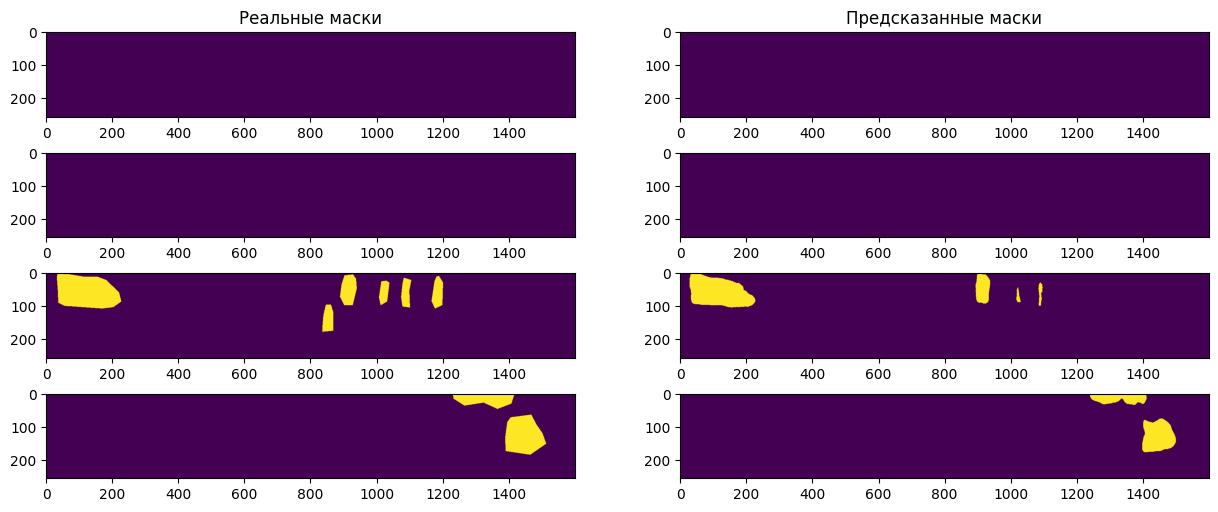

In [16]:
img_id = '0025bde0c.jpg'
show_res(img_id, df)

         ImageId  ClassId                                      EncodedPixels
0  0002cc93b.jpg        1  29102 12 29346 24 29602 24 29858 24 30114 24 3...
Dice score для 0002cc93b.jpg: tensor([0.7486, 1.0000, 1.0000, 1.0000], device='cuda:0') tensor(0.9371, device='cuda:0')


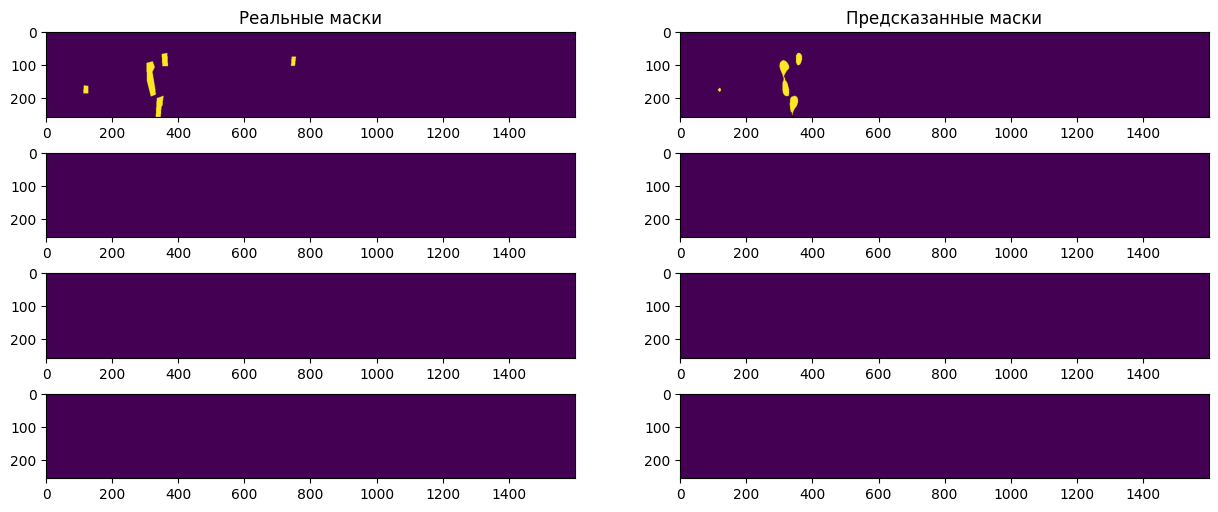

In [17]:
img_id = '0002cc93b.jpg'
show_res(img_id, df)

            ImageId  ClassId  \
7093  ffff4eaa8.jpg        3   

                                          EncodedPixels  
7093  16899 7 17155 20 17411 34 17667 47 17923 60 18...  
Dice score для ffff4eaa8.jpg: tensor([1.0000, 1.0000, 0.9071, 1.0000], device='cuda:0') tensor(0.9768, device='cuda:0')


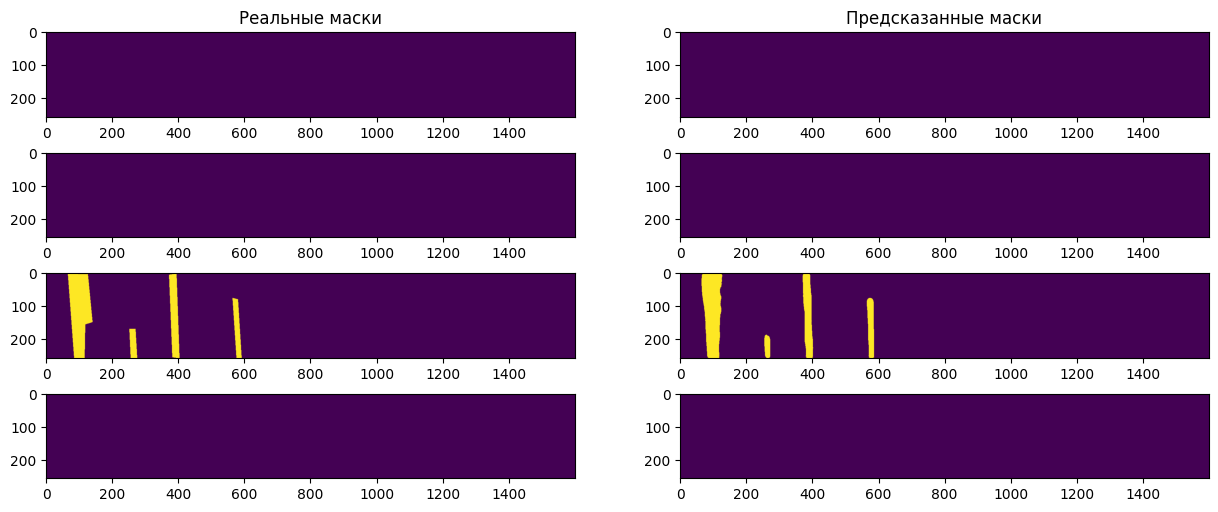

In [47]:
img_id = 'ffff4eaa8.jpg'
show_res(img_id, df)